In [1]:
function hebbian_adjust!(S, fired, rewiring_rate, rowsums_weights, neurontype_idx)
    if length(fired) < 2
        return nothing
    end
    
    for i in fired
        wire_this_to = falses(size(S, 1))
        wire_this_to[fired] .= true
        unwire_this_from = .!wire_this_to
        
        inc_weights_sum = rowsums_weights[i]
        count_wire = length(fired)
        count_unwire = size(S, 1) - count_wire
        
        wire_by = rewiring_rate * inc_weights_sum / count_wire
        unwire_by = rewiring_rate * inc_weights_sum / count_unwire
        
        S[i, wire_this_to] .= S[i, wire_this_to] .+ wire_by * neurontype_idx[wire_this_to]
        S[i, unwire_this_from] .= S[i, unwire_this_from] .- unwire_by * neurontype_idx[unwire_this_from]
        
        # remove reflectivity (a neuron is always *wired* to itself)
        S[i, i] -= wire_by * neurontype_idx[i]
    end
    
    return nothing
end


hebbian_adjust! (generic function with 1 method)

In [2]:
# ported from matlab
using DelimitedFiles;
using Statistics;
using Plots;
using BenchmarkTools;

In [3]:
# SET UP THE NETWORK
# 1- NETWORK SIZE:
A = readdlm("grow_axons/test_colonies/W_2023-05-08_15-45-39.118865.txt")
Pe = 0.8  # excitatory fraction; change in grow_axons
Ne = ceil(Int, Pe * size(A, 1))
Ni = floor(Int, (1 - Pe) * size(A, 1))
T = 500;  # time steps

In [4]:
# 2 - GLOBAL PARAMETERS THAT SET OUR NEURON MODEL. DEFAULT IS SPIKING NEURON:
# Set initial conditions of neurons, with some variability provided by the
# vectors re and ri containing random numbers between 0 and 1.
re = rand(Ne)
ri = rand(Ni)
a = [0.02 * ones(Ne); 0.02 .+ 0.08 * ri];
b = [0.2 * ones(Ne); 0.25 .- 0.05 * ri];
c = [-65 .+ 15 * re .^ 2; -65 * ones(Ni)];
d = [8 .- 6 * re .^ 2; 2 * ones(Ni)];


In [5]:
# 3 - SET UP THE CONNECTIVITY MATRIX: DIRECTED NETWORK
# In this construction, 1 = connection exist, 0 = no connection.
# Connectivity is set as random. Then, a fraction of connections are set to 0.
# Note that effectively this is an Erdös-Rényi graphs, with no spatial
# characteristics.
#frac_delete = 0.6  # Set this fraction of connections to zero.
#A[A .< frac_delete] .= 0;
#A[A .> 0] .= 1;

In [6]:
# 4 - SET SYNAPTIC WEIGHTS (STRENGTHS) OF CONNECTIONS.
# I represents the amplitudes of evoked currents (EPSC and IPSC).
# Increase the max. excitatory weight to induce synchronization.
# Be careful. The balance between excitation and inhibition governs the
# dynamics of the network!
MAX_EXC_WEIGTH = 5.0
MAX_INH_WEIGTH = 0.5
S = copy(A)
S[S .> 0] .= MAX_EXC_WEIGTH * A[A .> 0] .* rand(sum(A .> 0))
S[S .< 0] .= MAX_INH_WEIGTH * A[A .< 0] .* rand(sum(A .< 0));


In [7]:
# 6 - DEFINE NOISE STRENGTH. Remember that noise (or random inputs) is the
# main drive of spontaneous activity. Default is around 5.
NOISE_MAX = 5.0;

In [8]:
T = 300000

300000

In [9]:
Is = zeros(Ne + Ni, T)
v = -65.0 * ones(Ne + Ni)
u = b .* v
firings = zeros(Ne + Ni, T)
rowsums_weights = sum(A, dims=1)
neurontype_idx = [ones(Ne); -ones(Ni)]
for t = 1:T
    I = [NOISE_MAX * randn(Ne); 2 * randn(Ni)]
    fired = findall(v .>= 30)
    firings[fired, t] .= 1
    # plasticity
    # S, x, u = short_term_plasticity(S, fired, y, x, 200, 600, 0.2)
    # S = hebbian_adjust_network_homeostasis(S, fired, 0.05)
    hebbian_adjust!(S, fired, 0.05, rowsums_weights, neurontype_idx)
    v[fired] .= c[fired]
    u[fired] .= u[fired] .+ d[fired]
    I .+= sum(S[:, fired], dims=2)
    Is[:, t] = I
    v .= v .+ 0.5 .* (0.04 .* v .^ 2 .+ 5 .* v .+ 140 .- u .+ I)  # step 0.5 ms
    v .= v .+ 0.5 .* (0.04 .* v .^ 2 .+ 5 .* v .+ 140 .- u .+ I)  # for numerical stability
    u .= u .+ a .* (b .* v .- u)
end


LoadError: OutOfMemoryError()

In [24]:
import Pkg; Pkg.add("UnicodePlots")

    Updating registry at `C:\Users\stefa\.julia\registries\General.toml`
   Resolving package versions...
   Installed MarchingCubes ──── v0.1.8
   Installed StaticArraysCore ─ v1.4.0
   Installed Crayons ────────── v4.1.1
   Installed StaticArrays ───── v1.6.0
   Installed UnicodePlots ───── v3.6.0
    Updating `C:\Users\stefa\.julia\environments\v1.8\Project.toml`
  [b8865327] + UnicodePlots v3.6.0
    Updating `C:\Users\stefa\.julia\environments\v1.8\Manifest.toml`
  [a8cc5b0e] + Crayons v4.1.1
  [299715c1] + MarchingCubes v0.1.8
  [90137ffa] + StaticArrays v1.6.0
  [1e83bf80] + StaticArraysCore v1.4.0
  [b8865327] + UnicodePlots v3.6.0
Precompiling project...
  ✓ StaticArraysCore
  ✓ Crayons
  ✓ StaticArrays
  ✓ MarchingCubes
  ✓ UnicodePlots
  5 dependencies successfully precompiled in 335 seconds. 173 already precompiled.


In [48]:
# PLOT RESULTS
# Raster plot. Time on X, neuron on Y.
gr()
heatmap(firings)

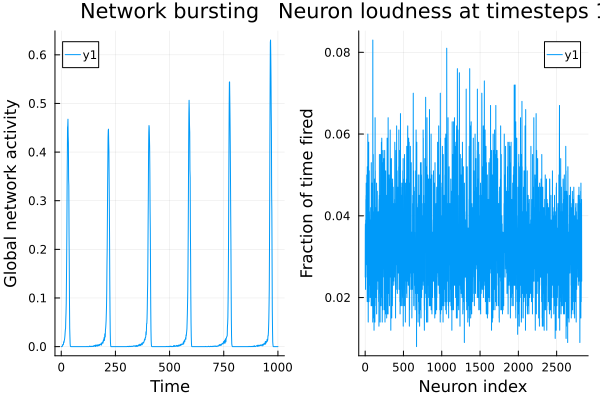

In [38]:

spike_m = firings

p1 = plot(1:T, (sum(spike_m, dims=1) / size(spike_m, 1))')
title!("Network bursting")
xlabel!("Time")
ylabel!("Global network activity")

subset = 1:size(spike_m, 2)
p2 = plot(sum(spike_m[:, subset], dims=2) / size(spike_m[:, subset], 2))
title!("Neuron loudness at timesteps $(subset[1]):$(subset[end])")
xlabel!("Neuron index")
ylabel!("Fraction of time fired")
plot(p1, p2, layout = (2,1))

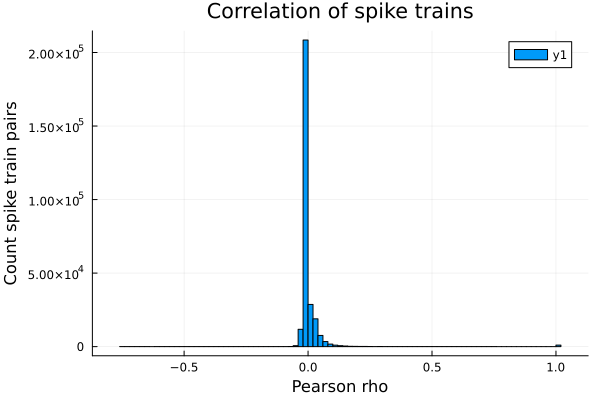

In [40]:
# firing statistics
c = cor(spike_m, dims=1)
corrplot = c[:]
histogram(corrplot, bins=100)
title!("Correlation of spike trains")
xlabel!("Pearson rho")
ylabel!("Count spike train pairs")


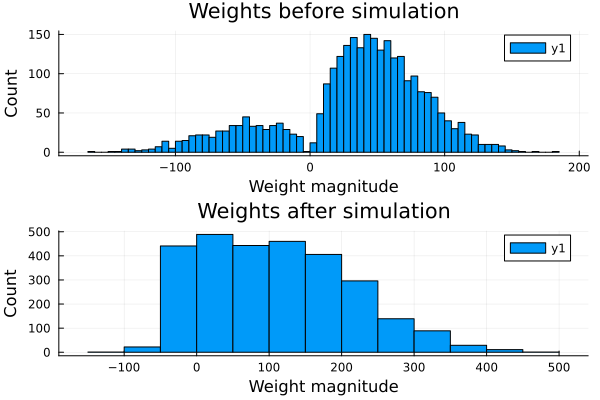

In [43]:
p1 = histogram(sum(A, dims=1)', bins=100)
title!("Weights before simulation")
xlabel!("Weight magnitude")
ylabel!("Count")

p2 = histogram(sum(S, dims=1)', bins=20)
title!("Weights after simulation")
xlabel!("Weight magnitude")
ylabel!("Count")
plot(p1, p2, layout = (2,1))

In [ ]:
subplot(2, 1, 1)
heatmap(S, colormap=:hot, colorbar=:true)
title!("Weights after simulation")

subplot(2, 1, 2)
heatmap(A, colormap=:hot, colorbar=:true)
title!("Weights before simulation")
